In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, cv2

from Utils import get_image_filepaths, get_data, dice_coef
from Unet import UNet, build_unet

import warnings
warnings.filterwarnings('ignore')

2023-07-14 21:32:06.291368: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 21:32:06.322616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 21:32:06.775849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
psysical_device = tf.config.list_physical_devices('GPU')
print(psysical_device)
tf.config.experimental.set_memory_growth(psysical_device[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-07-14 21:32:07.480380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:32:07.520788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:32:07.520903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
SEED = 777
rng = tf.random.Generator.from_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

2023-07-14 21:32:07.528125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:32:07.528291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:32:07.528369: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
img_size = 512 # 512 # 496 # 512  # 320
IMAGE_SIZE = (img_size, img_size)
BATCH_SIZE = 3
# Init params
main_path = '/home/suetin/Projects/HeartSegmentation/Data' # r'.../../Data'
print(os.listdir(main_path))
img_path = os.path.join(main_path, 'images')
msk_path = os.path.join(main_path, 'masks')

['masks', 'images', 'not_predicted']


In [5]:
# Get all names of photoes
img_paths = [os.path.join(img_path, name) for name in os.listdir(img_path)]
msk_paths = [os.path.join(msk_path, name) for name in os.listdir(msk_path)]
# Load data in array
X_test = get_data(paths=img_paths, img_shape=IMAGE_SIZE, as_mask=False)
y_test = get_data(paths=msk_paths, img_shape=IMAGE_SIZE, as_mask=True)

y_test.shape

100%|██████████| 400/400 [00:00<00:00, 1010.54it/s]


(400, 512, 512, 1)

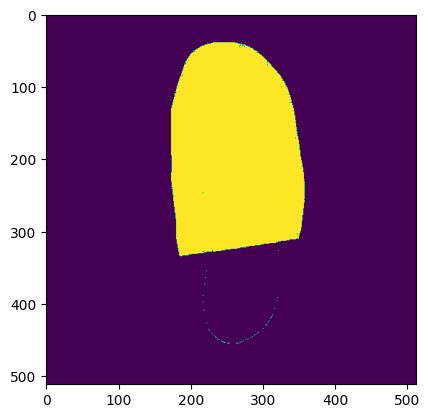

In [6]:
plt.imshow(y_test[0])

In [7]:
@tf.function
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [8]:
model = build_unet(input_shape=(IMAGE_SIZE + (1,)))
# Load model' weights
weights_path = r'/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/TensorFlow/dev/Weights/UNet-v1.h5'  # r'/home/suetin/Projects/VSCode/ComputerVision/HeartSegmentation/TensorFlow/Pipeline v1/Docker/U512_bs.h5'
model.load_weights(weights_path)

In [9]:
""" The worst predict """
dices = []

for i in range(len(X_test)):
    pred = model.predict(X_test[i:i + 1], verbose=0)
    # eval = model.evaluate(X_test[i:1 + 1])
    dice = dice_coef(y_test[i:i + 1].astype(np.float32), pred).numpy()
    dices.append([i, dice])

dices = np.array(dices)
sorted_dice = dices[dices[:, 1].argsort()]

2023-07-14 21:32:10.642848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902


1/1 [==============================] - 0s 14ms/step


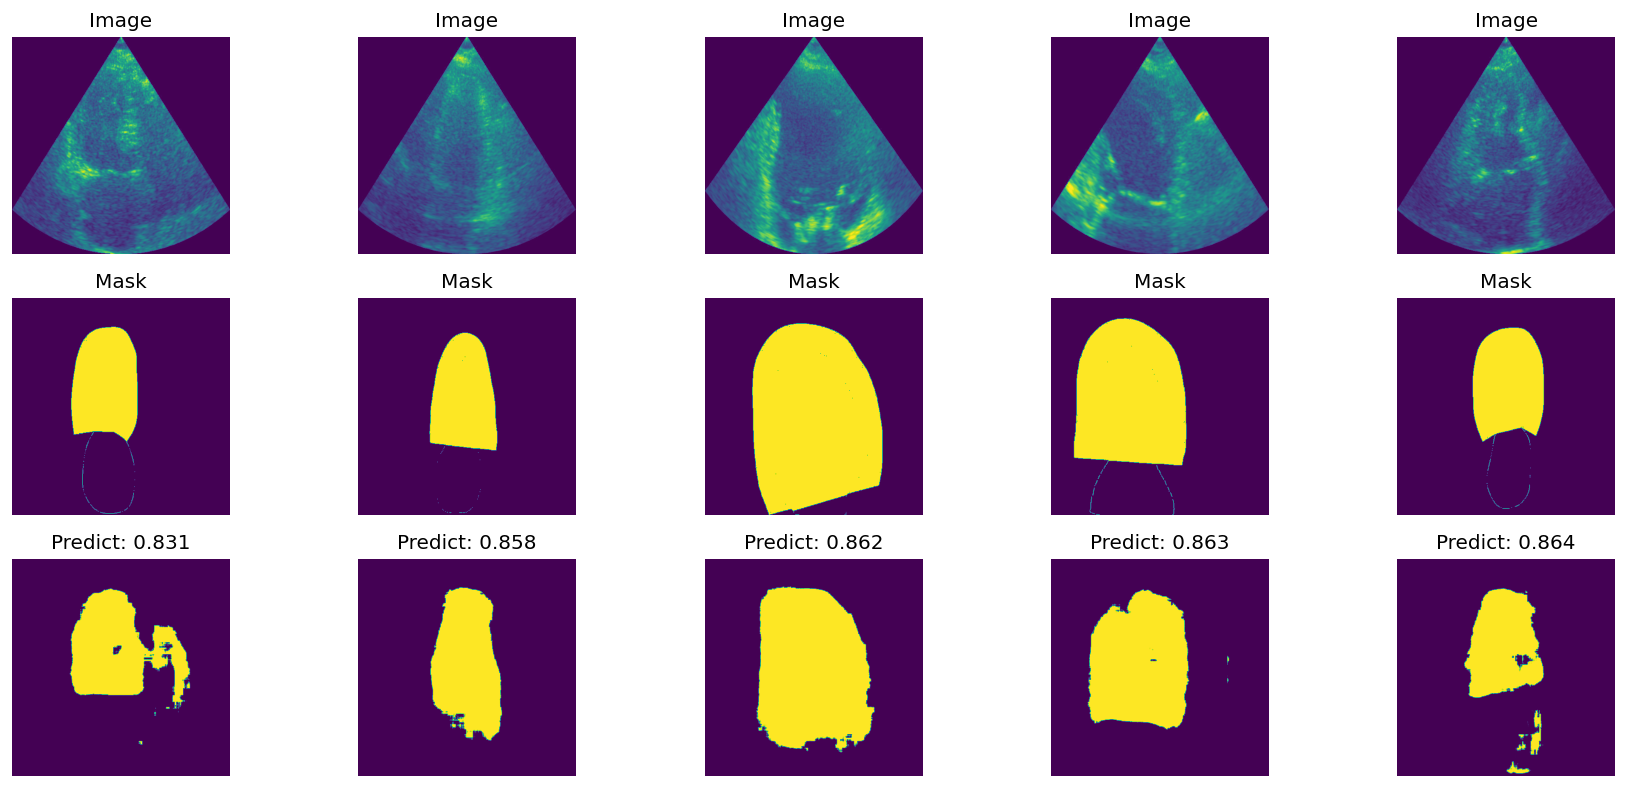

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

for j, (i, val) in enumerate(sorted_dice[:5]):
    i = int(i)

    ax[0, j].set_title('Image')
    ax[0, j].set_axis_off()
    ax[0, j].imshow(X_test[i])

    ax[1, j].set_title('Mask')
    ax[1, j].set_axis_off()
    ax[1, j].imshow(y_test[i])

    pred = model.predict(X_test[i:i + 1])
    ax[2, j].set_title(f'Predict: {round(val, 3)}')
    ax[2, j].set_axis_off()
    ax[2, j].imshow(pred[0])

plt.show()

1/1 [==============================] - 0s 13ms/step


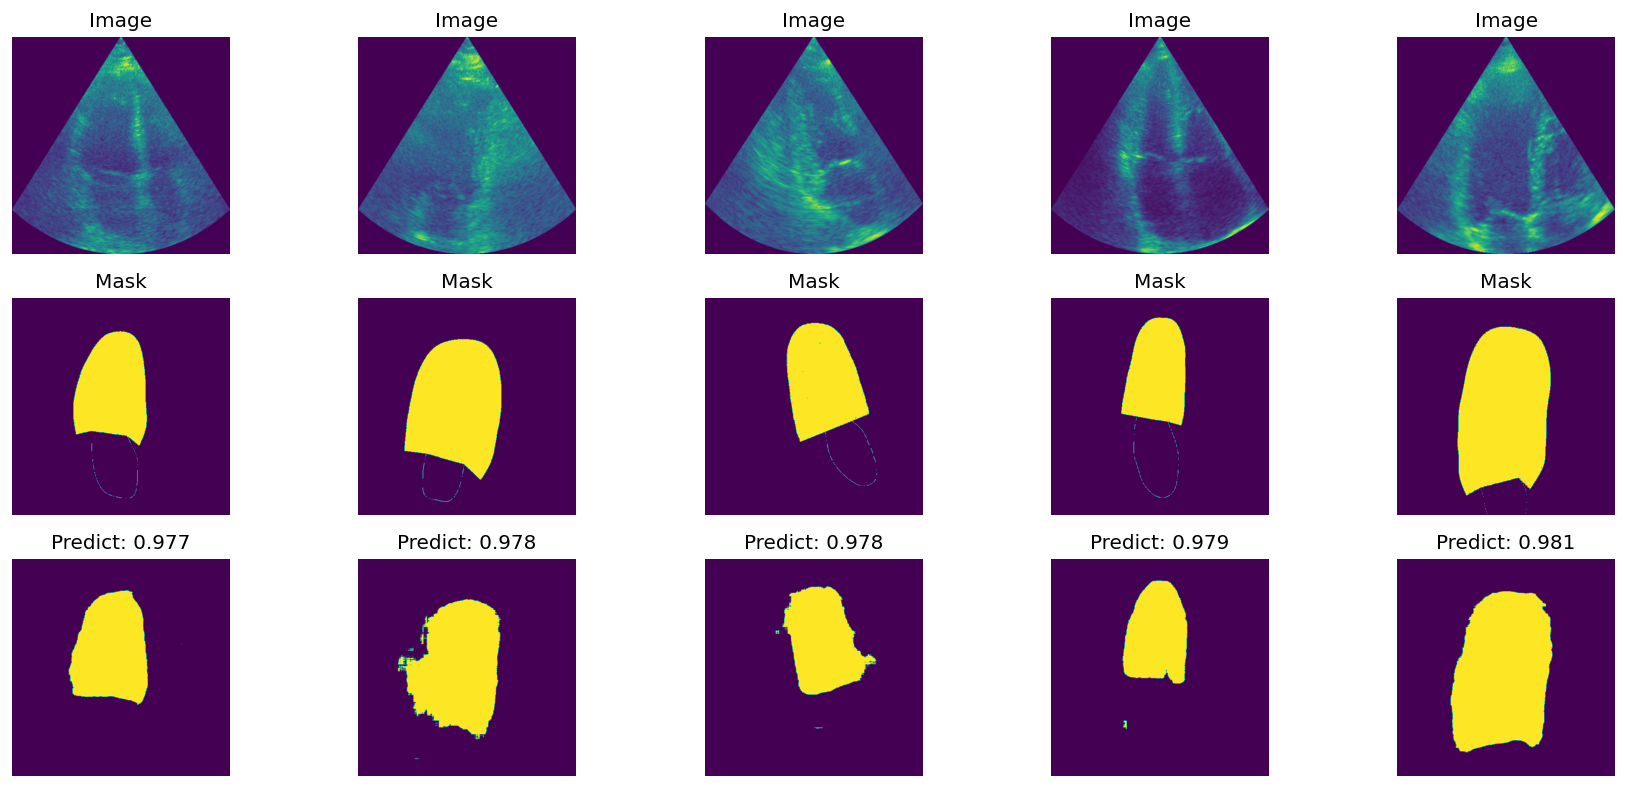

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

for j, (i, val) in enumerate(sorted_dice[-5:]):
    i = int(i)

    ax[0, j].set_title('Image')
    ax[0, j].set_axis_off()
    ax[0, j].imshow(X_test[len(sorted_dice) - i - 1])

    ax[1, j].set_title('Mask')
    ax[1, j].set_axis_off()
    ax[1, j].imshow(y_test[len(sorted_dice) - i - 1])

    pred = model.predict(X_test[len(sorted_dice) - i - 1:len(sorted_dice) - i])
    ax[2, j].set_title(f'Predict: {round(val, 3)}')
    ax[2, j].set_axis_off()
    ax[2, j].imshow(pred[0])

plt.show()

In [21]:
import keras

# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save(r"Weights/echo_model.keras")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("Weights/echo_model.keras")

# Let's check:
np.testing.assert_allclose(
    model.predict(X_test[0:1]), reconstructed_model.predict(X_test[0:1])
)


1/1 [==============================] - 0s 14ms/step
(1, 512, 512, 1)
1/1 [==============================] - 0s 210ms/step
(1, 512, 512, 1)
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


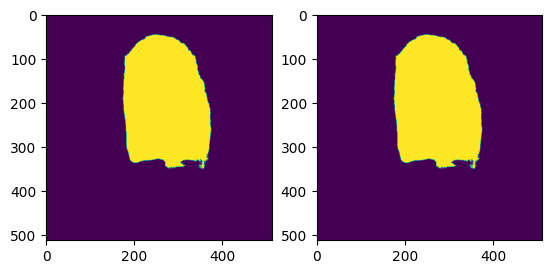

In [24]:
plt.subplot(121)
plt.imshow(model.predict(X_test[0:1])[0])
plt.subplot(122)
plt.imshow(reconstructed_model.predict(X_test[0:1])[0])